# Interpretable Machine Learning

## Load Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import eli5
from sklearn.inspection import plot_partial_dependence
import shap

Using TensorFlow backend.


## Load Dataset

In [2]:
house_data = pd.read_csv("./dataset/house-prices-advanced-regression-techniques/train.csv")

In [3]:
cancer_data = pd.read_csv("./dataset/cancer/data.csv")

In [9]:
import qgrid
qgrid_widget = qgrid.show_grid(cancer_data, show_toolbar=True)

In [10]:
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Data Inspections

In [4]:
house_data.isna().sum().sort_values()

Id                  0
TotalBsmtSF         0
Heating             0
SaleCondition       0
CentralAir          0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
SaleType            0
YrSold              0
MoSold              0
MiscVal             0
PoolArea            0
ScreenPorch         0
BsmtUnfSF           0
3SsnPorch           0
OpenPorchSF         0
WoodDeckSF          0
PavedDrive          0
GarageArea          0
                 ... 
YearBuilt           0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
ExterQual           0
ExterCond           0
Foundation          0
MSSubClass          0
YearRemodAdd        0
Utilities           0
Electrical          1
MasVnrType          8
MasVnrArea          8
BsmtQual  

In [5]:
cancer_data.isna().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

**Imputasi Data**

In [6]:
# imputasi data kategorik
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# Ganti nilai NA/NaN dengan 'NotAvail'
for col in cols_fillna:
    house_data[col].fillna('NotAvail',inplace=True)

# imputasi data numerik
house_data['LotFrontage'] = house_data['LotFrontage'].fillna(house_data['LotFrontage'].median(skipna=True))
house_data['GarageYrBlt'] = house_data['GarageYrBlt'].fillna(0)
house_data['MasVnrArea'] = house_data['MasVnrArea'].fillna(0)

In [7]:
house_data['MSSubClass'] = house_data['MSSubClass'].astype('object')

**One-Hot Encoding & Train-Test Split**

**Housing Data**

In [8]:
house_data = pd.get_dummies(house_data.iloc[:,1:])

In [9]:
house_data.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,0,0,0,1,0,0,0,0,1,0


In [10]:
house_data_y = house_data['SalePrice'].values
house_data_X = house_data.drop(columns='SalePrice').values
house_data_feature_names = house_data.drop(columns='SalePrice').columns.tolist()

**Cancer Data**

In [11]:
cancer_data_y = pd.get_dummies(cancer_data.iloc[:,1])['M'].values
cancer_data_X = cancer_data.iloc[:,2:].values
cancer_data_feature_names = cancer_data.iloc[:,2:].columns.tolist()

## Model-Based Method

### Linear Regression

Pada pemodelan regresi linear, kita dapat menggunakan bobot yang diperoleh dari model untuk menerjemahkan dan mencari tahu prediktor mana yang paling penting atau berkontribusi positif/negatif terhadap naiknya/turunnya nilai dari target.

Persamaan regresi:

$$y = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + ... + \beta_{n}x_{n} + \epsilon$$

Dimana:

- $\beta_{0}, ..., \beta_{n}$ adalah bobot/koefisien yang diperoleh dari model
- $\epsilon$ adalah nilai error

**Modeling**

In [12]:
model_regresi_linear = LinearRegression()
model_regresi_linear.fit(house_data_X, house_data_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Interpretasi**

In [13]:
eli5.explain_weights(model_regresi_linear, feature_names=house_data_feature_names)

Weight?,Feature
+249410.070,PoolQC_NotAvail
+144214.845,RoofMatl_Membran
+112066.451,RoofMatl_Metal
+107799.304,GarageQual_Ex
+102512.977,RoofMatl_WdShngl
+93254.491,Condition2_PosA
+77798.829,RoofStyle_Shed
+48337.462,RoofMatl_Tar&Grv
+47396.852,RoofMatl_CompShg
+46163.157,Condition2_Artery


### Logistic Regression

Sama halnya dengan model regresi linear, model logistic regression juga memiliki nilai bobot yang dapat diekstrak sehingga kita dapat mengetahui seberapa penting suatu variabel dibandingkan dengan variabel lainnya.

Persamaan regresi logistik adalah:

$$P(y=1) = \frac{1}{1+exp(-(\beta_{0} + \beta_{1}x_{1} + ... + \beta_{n}x_{n}))}$$

Dimana:

- P(y=1) adalah peluang terjadinya y=1
- $\beta_{0}, ..., \beta_{n}$ adalah bobot/koefisien yang diperoleh dari model

**Modeling**

In [14]:
model_regresi_logistik = LogisticRegression(penalty='none', solver='sag')
model_regresi_logistik.fit(cancer_data_X, cancer_data_y)

C:\Users\Elga Ridho Maulana\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
eli5.explain_weights(model_regresi_logistik, feature_names=cancer_data_feature_names)

Explanation(estimator="LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n                   intercept_scaling=1, l1_ratio=None, max_iter=100,\n                   multi_class='warn', n_jobs=None, penalty='none',\n                   random_state=None, solver='sag', tol=0.0001, verbose=0,\n                   warm_start=False)", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='area_worst', weight=0.018694498981104073, std=None, value=None), FeatureWeight(feature='area_se', weight=0.009469728277011832, std=None, value=None), FeatureWeight(feature='concavity_worst', weight=0.00011712327512079044, std=None, value=None), FeatureWeight(feature='concavity_mean', weight=5.9089343586130334e-05, std=None, value=None)], neg=[FeatureWeight(feature='perimeter_mean', weight=-0.028396008614441314, std=None, value=None), FeatureWeight(feature='perimeter_worst', weight=-0.02836988056327933, std=None, value=None), FeatureWeight(feature='area_mean', weight=-0.015267100003803845, std=None, value=None), FeatureWeight(feature='texture_worst', weight=-0.010562728025258804, std=None, value=None), FeatureWeight(feature='texture_mean', weight=-0.008354454819499459, std=None, value=None), FeatureWeight(feature='radius_worst', weight=-0.004913429987235207, std=None, value=None), FeatureWeight(feature='radius_mean', weight=-0.004788730035168755, std=None, value=None), FeatureWeight(feature='texture_se', weight=-0.0006571991074215241, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=-0.0006475922930214117, std=None, value=None), FeatureWeight(feature='symmetry_worst', weight=-0.00013349707143257567, std=None, value=None), FeatureWeight(feature='perimeter_se', weight=-0.00010285943295780242, std=None, value=None), FeatureWeight(feature='symmetry_mean', weight=-9.619418631143493e-05, std=None, value=None), FeatureWeight(feature='smoothness_worst', weight=-6.545051790893443e-05, std=None, value=None), FeatureWeight(feature='smoothness_mean', weight=-5.039529070704077e-05, std=None, value=None), FeatureWeight(feature='radius_se', weight=-4.225689800012718e-05, std=None, value=None), FeatureWeight(feature='fractal_dimension_worst', weight=-3.9725176401325516e-05, std=None, value=None)], pos_remaining=5, neg_remaining=6), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

### Decision Tree

Model decision tree merupakan model yang sangat mudah diterjemahkan dikarenakan bentuknya yang berupa susunan dari keputusan-keputusan. Ada beberapa metode bagaimana kita dapat menerjemahkan/menginterpretasi model yang dibentuk oleh decision tree ini, diantaranya:

- Feature Importance
- Tree Decomposition

**Feature Importance**

Feature Importance dihitung dengan cara sebagai berikut:

$$\frac{N_{t}}{N} \times (impurity - \frac{N_{t_{right}}}{N_{t}} \times right_{impurity} - \frac{N_{t_{left}}}{N_{t}} \times left_{impurity})$$

Dimana:

- $N_{t}$: total sampel pada node tersebut.
- $N$: total keseluruhan sampel
- $N_{t_{right}}$: total sampel pada node di split kanan
- $N_{t_{left}}$: total sampel pada node di split kiri
- $impurity$: Nilai impuritas

In [22]:
model_decision_tree = DecisionTreeClassifier(random_state=1000, max_depth=3)
model_decision_tree.fit(cancer_data_X, cancer_data_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1000, splitter='best')

In [23]:
eli5.sklearn.explain_decision_tree(model_decision_tree, feature_names=cancer_data_feature_names)

Weight,Feature
0.7569,radius_worst
0.1512,concave points_worst
0.0420,texture_worst
0.0340,texture_mean
0.0080,smoothness_worst
0.0080,symmetry_worst
0,compactness_se
0,perimeter_mean
0,area_mean
0,smoothness_mean


## Model-Agnostic Methods

Model-agnostic method dapat dianggap juga sebagai metode interpretasi model tanpa bergantung pada model itu sendiri.

Beberapa keuntungan dari penggunaan metode ini diantaranya adalah:

- *Model Flexibility*
- *Explanation Flexibility*
- *Representation Flexibility*

### Partial Dependence Plot (PDP)

Partial dependence plot (PDP) dapat digunakan untuk menunjukkan efek dari masing-masing variabel terhadap nilai prediksi. PDP dapat digunakan untuk menunjukkan apakah hubungan/kaitan antar variabel bersifat linear, monotonik, atau bentuk yang lebih kompleks.

C:\Users\Elga Ridho Maulana\Anaconda3\lib\site-packages\sklearn\inspection\partial_dependence.py:596: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\Elga Ridho Maulana\Anaconda3\lib\site-packages\sklearn\inspection\partial_dependence.py:596: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\Elga Ridho Maulana\Anaconda3\lib\site-packages\sklearn\inspection\partial_dependence.py:596: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.p

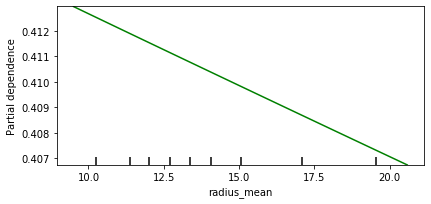

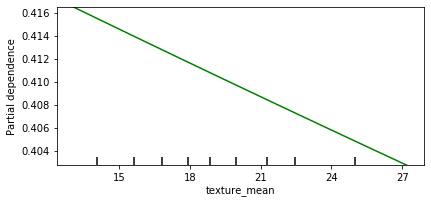

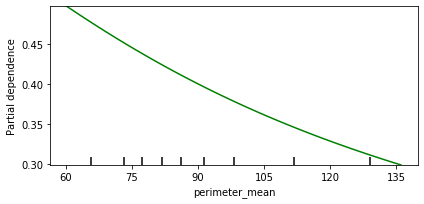

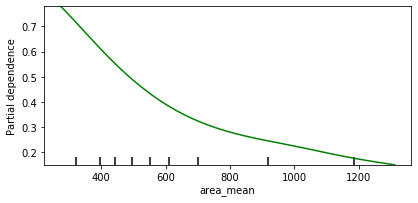

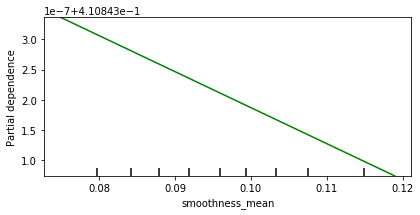

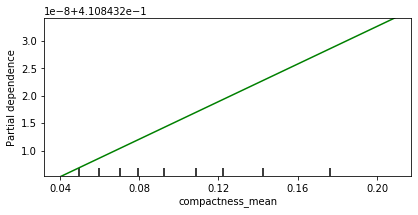

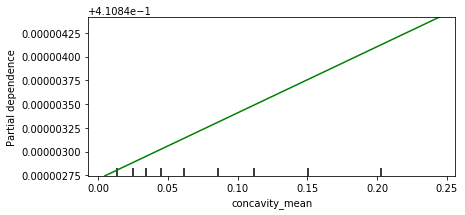

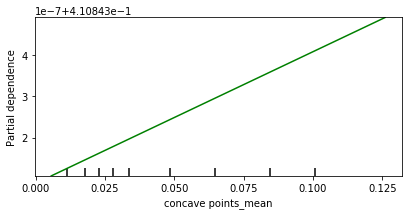

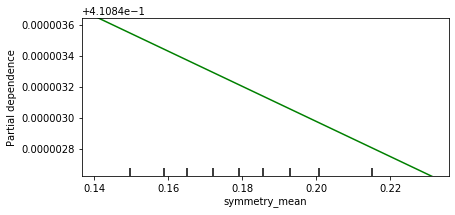

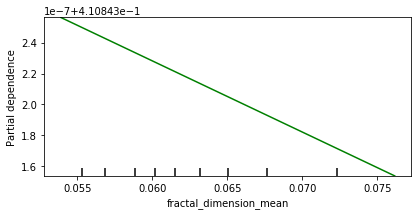

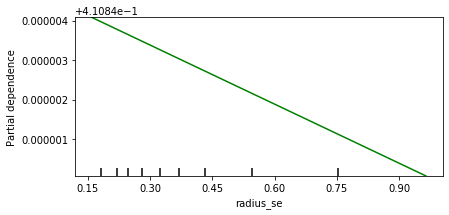

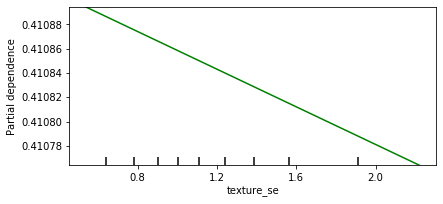

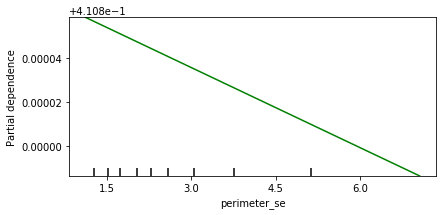

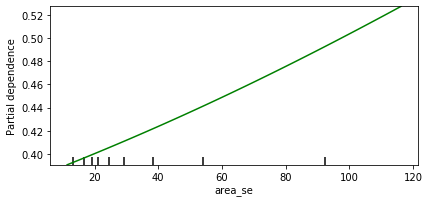

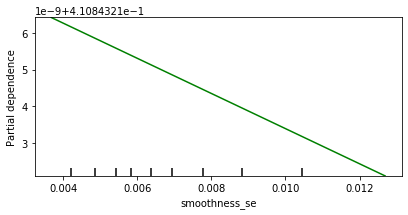

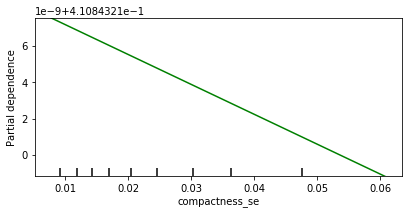

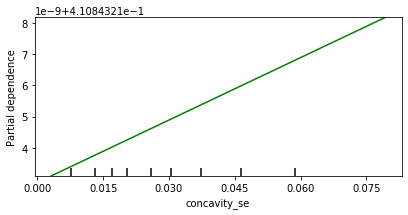

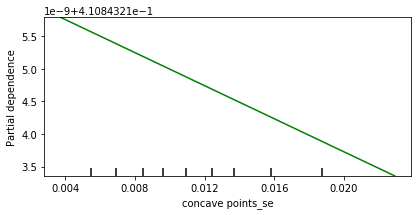

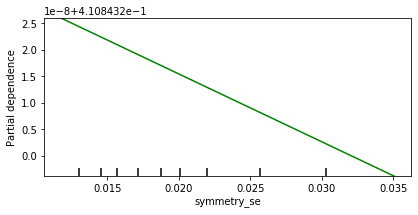

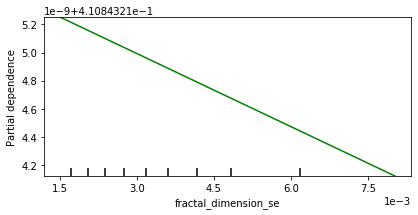

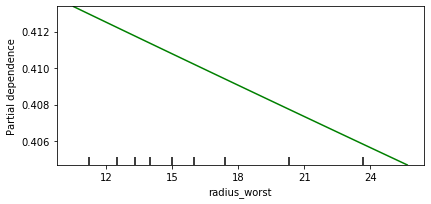

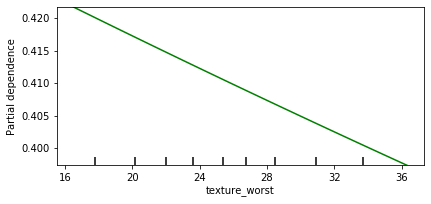

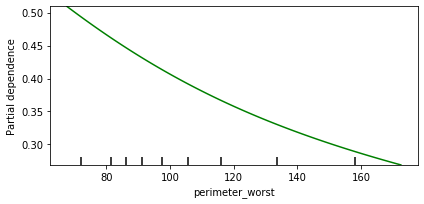

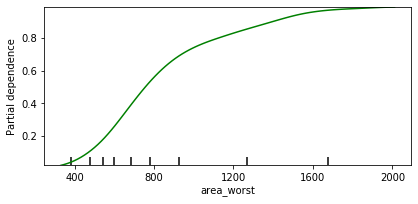

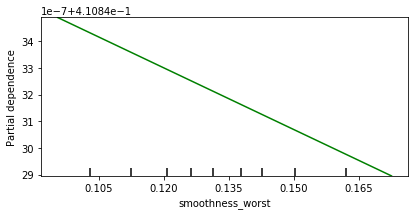

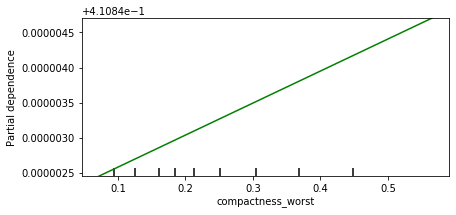

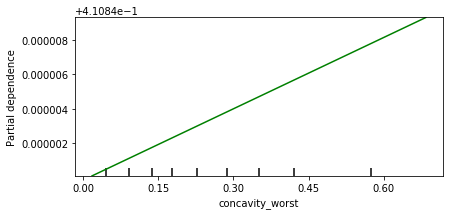

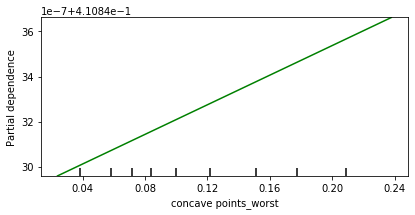

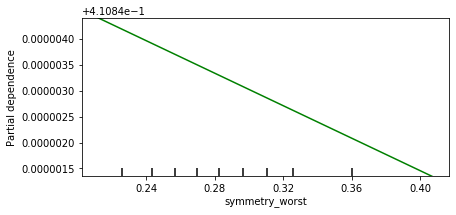

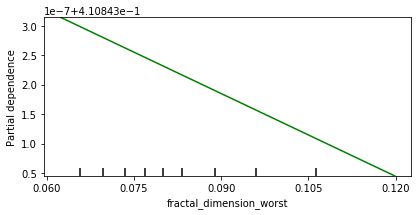

In [18]:
for kolom in range(len(cancer_data_feature_names)):
    plot_partial_dependence(model_regresi_logistik, cancer_data_X, features=[kolom], feature_names=cancer_data_feature_names);

### SHAP (SHapley Additive exPlanations) Feature Importance

SHAP adalah suatu metode yang digunakan untuk menjelaskan model berdasarkan nilai Shapley. Nilai Shapley diperoleh dengan cara menghitung nilai kontribusi yang diperoleh dari tiap variabel terhadap nilai prediksinya.

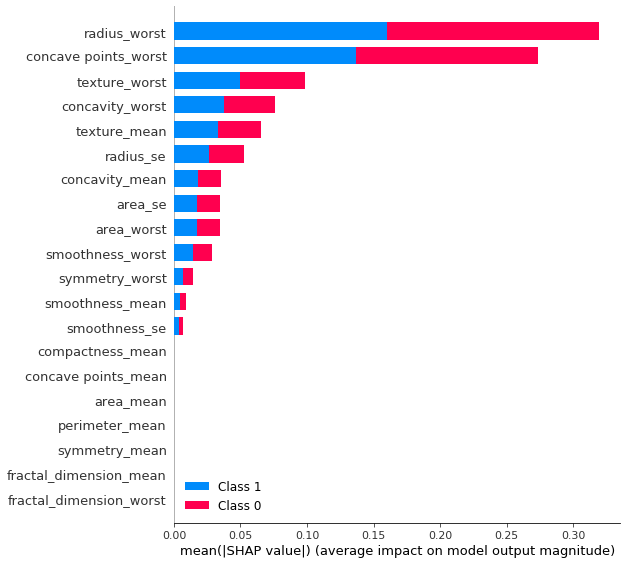

In [19]:
shap.initjs()
explainer = shap.TreeExplainer(model_decision_tree, cancer_data_X)
shap_values = explainer.shap_values(cancer_data_X, cancer_data_y)
shap.summary_plot(shap_values, cancer_data_X, feature_names=cancer_data_feature_names)

In [20]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [21]:
!jt -t solarizedd